### Important notes

A few important points:
1. In the `plot_results` function, the confidence bands were incorrectly plotted. Look at the correction that included the following: `conflev * np.sqrt ...`


1. A pedantic comment: when plotting 'discrete' data, it is better to plot the marker - adding a line to guide the viewer's eye is fine, but without the marker, it may give the false impression of a continuous function when it is really not continuous!


1. Stability of filter:

   One way to check stability numerically is to run the filter with the same original set of observations but with a different initial conditions for the filter (these are the variables `initial_state` and `initial_covariance`). Then you can look for the difference between the two filters (difference between filter means, difference between filter covariances) - You can see that these differences decrease exponentially with time, indicating exponential stability.


1. Convergence of filter covariance:

    One way to check convergence numerically is to check whether the sequence defined by the filter (analysis) covariance is a Cauchy sequence or not, i.e., plot $\|P^a_{n+1} - P^a_{n}\|$ as a function of $n$ - notice that in this case the filter is in fact convergent.


1. Modified filter with "inflated" or "deflated" covariance:

   If the forecast covariance is an over- or an under-estimate, the relative weightage given to the forecast, in comparison to the relative weight given to the observation, is an under- or an over-estimate, respectively. This can lead to "filter divergence" which refers to the case of a filter that is very precise but very inaccurate - the uncertainty (quantified by, for example, the standard deviation) is quite small compared to the bias (quantified by the distance to the true trajectory). This is illustrated by "artifically" multiplying the forecast covariance by a number that is chosen somewhat arbitrarily.

   **_Q: are the inflated or deflated filters stable? are they convergent?_**


In [138]:
%matplotlib inline

# Kalman Filter Exercise
This is the supplementary Python code for the Exercise 6.4 in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press". <br>
The exercise consists in completing the function `kf_predict_update` which has the signature:

```python

def update_method(x, cov, obs): 
    """ Update the state belief based on prior belief and new observation
    """
    # Do something
    return updated_x, updated_cov

```

## Standard imports

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg

np.random.seed(31415926)

## Utility functions

In [140]:
def mv_normal(m, C):
    """ Samples a multivariate normal of mean m and covariance C
    Example:
    >>> m = np.array([0., 0.])
    >>> C = np.eye(2)
    >>> mv_normal(m, C).size
    2
    """
    sample = np.random.randn(*m.shape)
    return m + linalg.cholesky(C, lower=True) @ sample

In [141]:
def rmse(x, y):
    """ Root mean square error between two vectors x and y
    Example:
    >>> x = np.ones(10)
    >>> y = np.ones(10) * 0.5
    >>> rmse(x, y)
    0.5
    """
    return np.sqrt(np.mean(np.square(x-y)))

In [142]:
def filter_routine(initial_guess, initial_guess_covariance, update_method, observations):
    """ Loops over the observations and calls the implemented update_method
    Example:
    >>> initial_guess = np.array([0, 0])
    >>> initial_covariance = np.eye(2)
    >>> def update_method(x, cov, obs): return x, cov
    >>> observations = np.random.randn(500)
    >>> states, state_covariances = filter_routine(initial_guess, initial_covariance, update_method, observations)
    >>> shape_ok = states.shape[0] == state_covariances.shape[0] == observations.shape[0]
    >>> values_ok = np.all(states == 0)
    >>> values_ok and shape_ok
    True
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]
    
    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))
    
    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov
    
    return states, covariances
    

In [143]:
def plot_results(filtered_states, true_states, observations, title, conflev, filtered_covariances=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True)
    
    T = observations.shape[0]
    
    axes[0,0].plot(filtered_states[:, 0], label="Estimated signal", marker="d", color="b")
    axes[0,0].plot(true_states[:, 0], label="True signal", linestyle='--', marker="*", color="r")
    axes[0,0].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1,0].plot(filtered_states[:, 1], label="Estimated derivative", marker="d", color="b")
    axes[1,0].plot(true_states[:, 1], label="True derivative", linestyle='--', marker="*", color="r")
    
    axes[0,1].plot(filtered_states[:, 2], label="2nd Estimated signal", marker="d", color="b")
    axes[0,1].plot(true_states[:, 2], label="2nd True signal", linestyle='--', marker="*", color="r")
    axes[0,1].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1,1].plot(filtered_states[:, 3], label="2nd Estimated derivative", marker="d", color="b")
    axes[1,1].plot(true_states[:, 3], label="2nd True derivative", linestyle='--', marker="*", color="r")
    
    error1 = rmse(filtered_states[:, 0:2], true_states[:, 0:2])
    error2= rmse(filtered_states[:, 2:4], true_states[:, 2:4])
    
    for ax in axes.flatten():
        ax.legend(loc="upper left")
    
    if filtered_covariances is not None:
        axes[0,0].fill_between(np.arange(T), 
                             filtered_states[:, 0] - conflev * np.sqrt(filtered_covariances[:, 0, 0]),
                             filtered_states[:, 0] + conflev * np.sqrt(filtered_covariances[:, 0, 0]),
                             alpha=0.33, 
                             color="b")
        axes[1,0].fill_between(np.arange(T), 
                             filtered_states[:, 1] - conflev * np.sqrt(filtered_covariances[:, 1, 1]),
                             filtered_states[:, 1] + conflev * np.sqrt(filtered_covariances[:, 1, 1]),
                             alpha=0.33, 
                             color="b")
        axes[0,1].fill_between(np.arange(T), 
                             filtered_states[:, 2] - conflev * np.sqrt(filtered_covariances[:, 2, 0]),
                             filtered_states[:, 2] + conflev * np.sqrt(filtered_covariances[:, 2, 0]),
                             alpha=0.33, 
                             color="b")
        axes[1,1].fill_between(np.arange(T), 
                             filtered_states[:, 3] - conflev * np.sqrt(filtered_covariances[:, 3, 1]),
                             filtered_states[:, 3] + conflev * np.sqrt(filtered_covariances[:, 3, 3]),
                             alpha=0.33, 
                             color="b")
        fig.suptitle(f"{title} and confidence intervals - RMSE1: {error1:.3f}, RMSE2: {error2:.3f}")
    else:
        fig.suptitle(f"{title} - RMSE1 = {error1:.3f}, RMSE2 = {error2:.3f}")


## Get data

We generate $T=100$ observations according to the following model: 
\begin{equation}
    x_t = A x_{t-1} + \mathcal{N}(0, Q), \quad y_t = \left(\begin{matrix}1 & 0\end{matrix}\right) x_t + \mathcal{N}(0, r), \quad x_0 = \left(\begin{matrix}0 & 0.1\end{matrix}\right)^T
\end{equation}

where we have $A = \left(\begin{matrix} \cos(\omega) & \frac{\sin(\omega)}{\omega} \\ -\omega \sin(\omega) & \cos(\omega)\end{matrix}\right), \quad 
Q = \frac 1 2 q \left(\begin{matrix}
                \frac{\omega - \cos(\omega) \sin(\omega)}{\omega^3} &
                \frac{\sin(\omega) ^2 }{\omega^2}   
            \\
                \frac{\sin(\omega) ^2 }{\omega^2}  &
                \frac{\omega + \cos(\omega) \sin(\omega)}{\omega} 
        \end{matrix}\right)$


For the remainder of the notebook, we will take: 
- $\omega = 0.5$
- $q = 0.01$
- $r = 0.1$

In [144]:
w = 0.5
q = 0.01
r = 0.1

T = 100
x_0 = np.array([0, 0.1, 0, 0])

In [145]:
def get_data(w, q, r, x_0, T):
    """ Generates data according to the state space model above
    Example:
    >>> observations, true_states, _, _, _ = get_data(0.25, 0.01, 0.1, np.array([0, 0.1]), 50)
    >>> observations.shape[0] == true_states.shape[0] == 50
    True
    """
    Q = 0.5 * q * np.array([[(w - np.cos(w) * np.sin(w)) / w ** 3, np.sin(w) ** 2 / w ** 2],
                            [np.sin(w) ** 2 / w ** 2, (w + np.cos(w) * np.sin(w)) / w]])
    
    Q_2= np.array([list(Q[0])+ [0,0], list(Q[1])+ [0,0], [0,0]+ list(Q[0]), [0,0]+ list(Q[1])])

    A = np.array([[np.cos(w), np.sin(w) / w], 
                  [-w * np.sin(w), np.cos(w)]])
    
    A_2= np.array([list(A[0])+ [0,0], list(A[1])+ [0,0], [0,0]+ list(A[0]), [0,0]+ list(A[1])])
    
    C = np.array([0, 0])
    
    C_2= np.array([1,0,0,0])
    
    observations = np.empty(T)
    true_states = np.empty((T, 4))
    
    x = x_0[:]
    true_states[0] = x
    
    for i in range(T):
        observations[i] = C_2.dot(x) + np.sqrt(r) * np.random.randn()
        x = mv_normal(np.matmul(A_2, x), Q_2)
        if i == T-1:
            break
        true_states[i+1, :] = x
        
    return observations, true_states, Q_2, A_2, C_2


In [146]:
observations, true_states, Q, A, C = get_data(w, q, r, x_0, T)

In [147]:
matrix_0= np.zeros(shape=Q.shape)
list(Q[0])+ [0,0]

[0.00317058030384207, 0.004596976941318603, 0.0, 0.0, 0, 0]

In [148]:
def plot_state(observations, true_states, T):
    fig, ax = plt.subplots(2,1,figsize=(12, 6),sharex='all')
    ax[0].plot(true_states[:, 0], linestyle='--', label="True Signal")
    ax[0].scatter(np.arange(T), observations, marker='o', label="Measurements")
    ax[0].legend(loc="upper left")
    ax[1].plot(true_states[:, 1], linestyle='--', label="True Signal")
    ax[1].set_xlabel("Time step")
    ax[1].legend(loc="upper left")
    fig.suptitle("Simulated data")

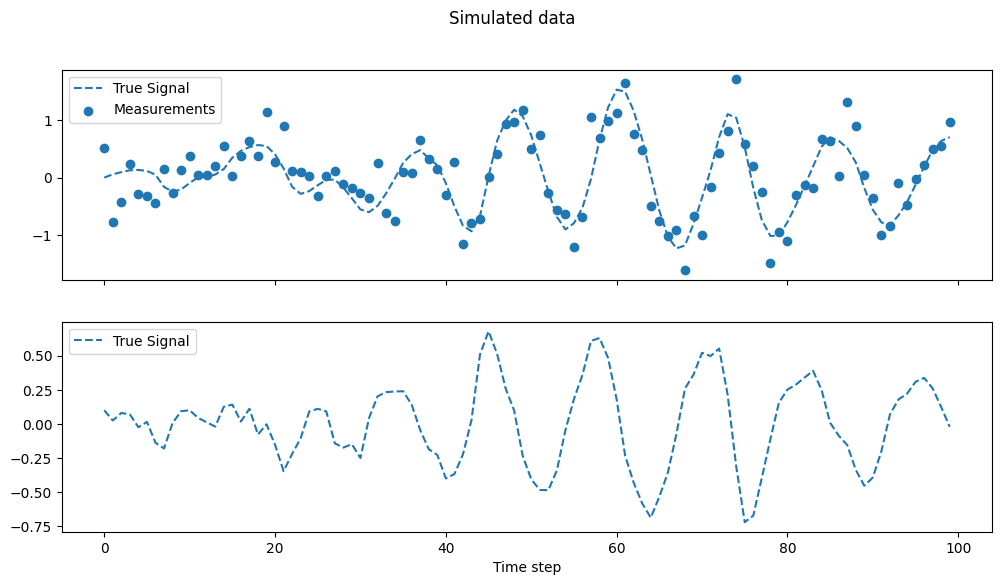

In [149]:
plot_state(observations, true_states, T)

## Initial Guess

We will now consider that our initial guess for the first state is given by $x_0 \sim \mathcal{N}\left(\left(\begin{matrix}0 \\ 1\end{matrix}\right), I_2\right)$

In [150]:
initial_state = np.array([0, 1, 2, 5])
initial_covariance = np.eye(4)

## Kalman Filter

In [151]:
def kf_update_predict(x, cov, obs):
    """ Implements the kalman equations as given in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press", Ch. 6.3
    Uses the global variables A, Q, C, r

    THIS FUNCTION reverses the order: update first and then forecast! how will you use this one??
    """
    # You should replace the below equations
    # x is xfmean = forecast mean
    # cov is pfcov = forecast covariance
    ###### kalmangain =  cov @ C.T @ np.linalg.inv( C @ cov @ C.T + r) 
    kalmangain =  cov @ C.T / ( C @ cov @ C.T + r) 
    # kalman gain (using forecast covariance)
    ###### xamean = x + kalmangain @ (obs - C @ x)  # analysis mean
    xamean = x + kalmangain * (obs - C @ x)  # analysis mean
    ###      pacov =  cov - kalmangain * C @ cov  # analysis covariance
    pacov =  cov - kalmangain @ kalmangain.T * ( C @ cov @ C.T + r)  # analysis covariance
    # 'new_x' will be new xfmean = forecast mean at next time
    # 'new_cov' will be new pfcov = forecast covariance at next time
    new_x = A @ xamean
    new_cov = A @ pacov @ A.T + Q
    return new_x, new_cov

In [152]:
def kf_predict_update(x, cov, obs):
    """ Implements the kalman equations as given in "Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed. Cambridge University Press", Ch. 6.3
    Uses the global variables A, Q, C, r
    """
    # You should replace the below equations
    #### forecast
    xfmean = A @ x
    pfcov = (A @ cov @ A.T + Q ) * 5
    #### update - but first calculate K = Kalman Gain
    kalmangain =  pfcov @ C.T / ( C @ pfcov @ C.T + r) 
    new_x = xfmean + kalmangain * (obs - C @ xfmean)  # analysis mean
    new_cov = pfcov - kalmangain @ C * pfcov
    return new_x, new_cov

In [153]:
kalman_states, kalman_covariances = filter_routine(initial_state, initial_covariance, kf_predict_update, observations)

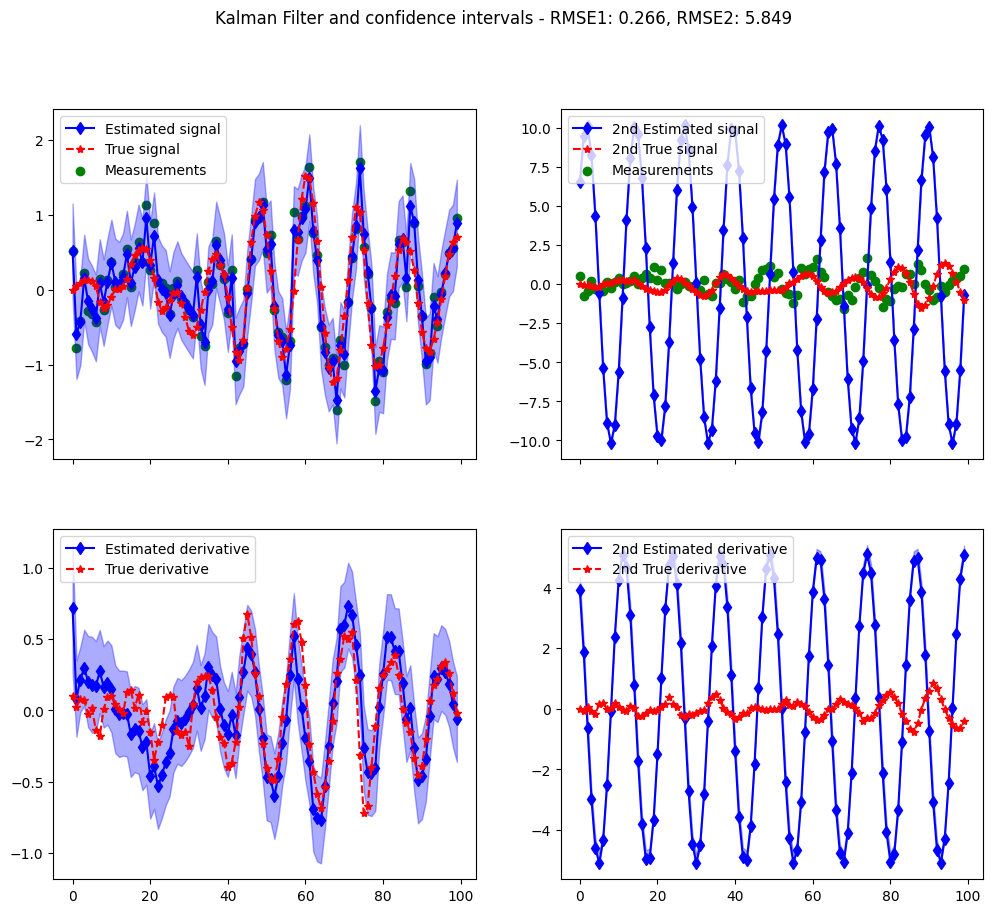

In [154]:
plot_results(kalman_states, true_states, observations, "Kalman Filter", 2.0, kalman_covariances)

### Stability

Choose different initial condition and compare with the previous run

In [155]:
initial_state = np.array([1.5, 2.3, 2, 4])
initial_covariance = kalman_covariances[80] * 5.8

In [156]:
kalman_states1, kalman_covariances1 = filter_routine(initial_state, initial_covariance, kf_predict_update, observations)

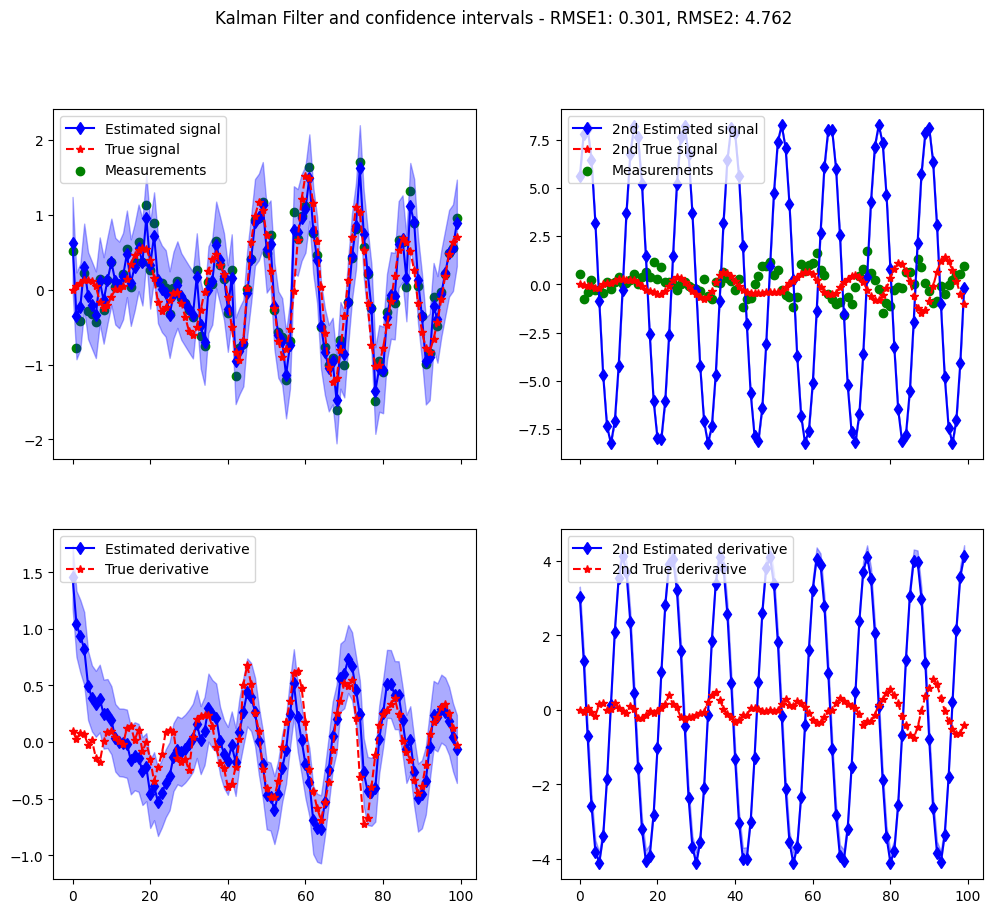

In [157]:
plot_results(kalman_states1, true_states, observations, "Kalman Filter", 2.0, kalman_covariances1)

### Plot the differences between the two different runs of the filter

In [158]:
mdf1 = kalman_states - kalman_states1
cdf1 = kalman_covariances - kalman_covariances1

Text(0.5, 0, 'iterations')

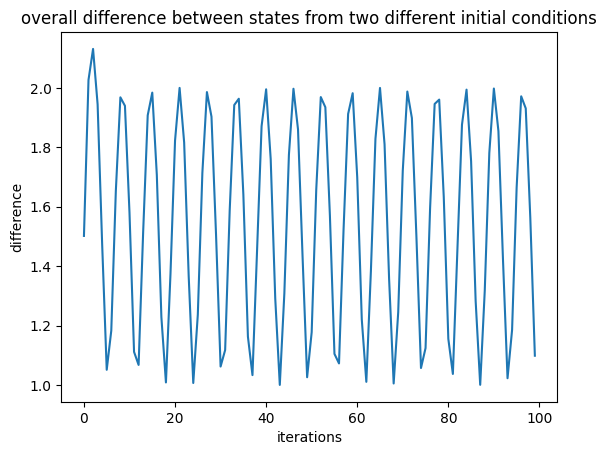

In [159]:
plt.plot(np.linalg.norm(mdf1, axis=1))
plt.title("overall difference between states from two different initial conditions")
plt.ylabel("difference")
plt.xlabel("iterations")

In [160]:
mdf_1= [np.linalg.norm(mdf1[ii,:][0:2]) for ii in range(100)]
mdf_2= [np.linalg.norm(mdf1[ii,:][2:4]) for ii in range(100)]

Text(0.5, 0, 'iterations')

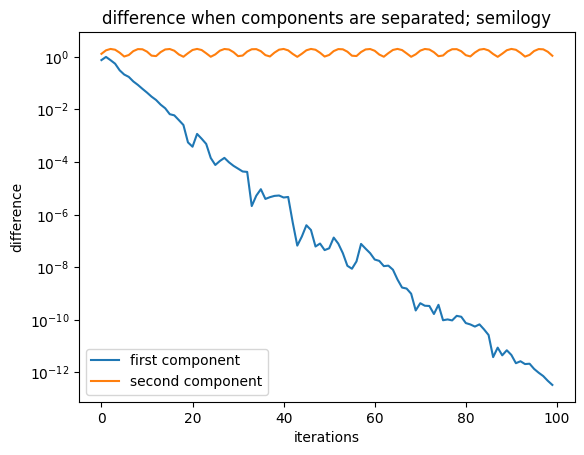

In [161]:
plt.semilogy(mdf_1, label="first component")
plt.semilogy(mdf_2, label="second component")
plt.legend()
plt.title("difference when components are separated; semilogy")
plt.ylabel("difference")
plt.xlabel("iterations")